# Homework 3 - Attacks and Defenses in Federated Learning
In this assignment, we will further explore the impact of various attacks and corresponding defenses within the context of federated learning.

# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

#### Endrit Jakupi, 24-119-299

In [1]:
from google.colab import files
uploaded = files.upload()

Saving hfl_complete.py to hfl_complete.py


In [2]:
from hfl_complete import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torch.optim import SGD, Optimizer
from torchvision import datasets, transforms
from dataclasses import dataclass
from time import perf_counter
from tqdm import tqdm
import gc

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.91MB/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
sample_split = split(100, False, 42)  # Non-i.i.d. Data

## Question 1: Influence of Non-I.I.D. Data in Attacks and Defenses (4 points)

Using the template code from [attacks_and_defenses.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_3/attacks_and_defenses.ipynb), experiment with how non-i.i.d. data distributions influence the performance of attacks and defenses. Utilize the `AttackerGradientReversion` for the attack. Keep all hyperparameters the same as those in the template code, except modify the data distribution among the clients to be non-i.i.d.

### Scoring:

- _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`.
- _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.
- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism.

In [5]:
class GradWeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: initial_weights - final_weights
        gradients = [initial_weight - final_weight for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]
        return [gradient.detach().cpu().clone() for gradient in gradients]

class FedAvgGradServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            # Other code remains the same until the aggregation part
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data


            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [6]:
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

In [7]:
def krum(clients_updates, n=20, m=4):
    # Number of neighboring updates to consider
    n_neighbors = n - m - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum((param_i - param_j).pow(2).sum()
                               for param_i, param_j in zip(clients_updates[i][1], clients_updates[j][1]))
                distances.append(distance)

        # Get the n_neighbors smallest distances
        nearest_distances = sorted(distances)[:n_neighbors]
        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]

def multi_krum(clients_updates, k=14, n=20, m=5):
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(k):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(remaining_updates,n-i,m)[0]

        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)

        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices

def majority_sign_filter(all_updates):
    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))

    # Calculate sign and count for determining majority
    all_signs = [torch.sign(torch.stack(parameter_group, dim=0)) for parameter_group in parameter_wise_updates]

    # Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]

    # Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []

        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)

        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average*20)

    return filtered_updates

In [8]:
class FedAvgServerDefense(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(len(client_updates))  # Use all updates if no defense is specified
            print(f'The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}')
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients[selected_indices])
            chosen_adjusted_weights = [
                [self.client_sample_counts[indices_chosen_clients[ind]] / chosen_sum_nr_samples * tens for tens in client_updates[ind][1]]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data


            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [9]:
class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int, seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs, self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]


            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data


            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result

In [ ]:
# 1. No Defense
fedavg_server_no_defense = FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42)
clients = fedavg_server_no_defense.clients
num_malicious = int(0.20 * len(clients))
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    clients[idx] = AttackerGradientReversion(client_data, 0.02, 200, 2)

result_no_defense = fedavg_server_no_defense.run(10)
df_no_defense = result_no_defense.as_df()

# 2. Krum
fedavg_server_krum = FedAvgServerDefense(0.02, 200, sample_split, 0.2, 2, 42, defense=krum)
clients = fedavg_server_krum.clients
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    clients[idx] = AttackerGradientReversion(client_data, 0.02, 200, 2)

result_krum = fedavg_server_krum.run(10)
df_krum = result_krum.as_df()

# 3. Multi-Krum
fedavg_server_multi_krum = FedAvgServerDefense(0.02, 200, sample_split, 0.2, 2, 42, defense=multi_krum)
clients = fedavg_server_multi_krum.clients
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    clients[idx] = AttackerGradientReversion(client_data, 0.02, 200, 2)

result_multi_krum = fedavg_server_multi_krum.run(10)
df_multi_krum = result_multi_krum.as_df()

# 4. Majority Sign
fedavg_server_majority_sign = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=majority_sign_filter)
clients = fedavg_server_majority_sign.clients
for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    clients[idx] = AttackerGradientReversion(client_data, 0.02, 200, 2)

result_majority_sign = fedavg_server_majority_sign.run(10)
df_majority_sign = result_majority_sign.as_df()

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [73]


Rounds:  10%|█         | 1/10 [00:07<01:11,  7.94s/it]

The following indices are selected in the training [69]


Rounds:  20%|██        | 2/10 [00:15<01:00,  7.62s/it]

The following indices are selected in the training [87]


Rounds:  30%|███       | 3/10 [00:23<00:54,  7.80s/it]

The following indices are selected in the training [54]


Rounds:  40%|████      | 4/10 [00:30<00:46,  7.67s/it]

The following indices are selected in the training [70]


Rounds:  50%|█████     | 5/10 [00:38<00:38,  7.74s/it]

The following indices are selected in the training [90]


Rounds:  60%|██████    | 6/10 [00:46<00:31,  7.75s/it]

The following indices are selected in the training [39]


Rounds:  70%|███████   | 7/10 [00:53<00:22,  7.63s/it]

The following indices are selected in the training [26]


Rounds:  80%|████████  | 8/10 [01:01<00:15,  7.74s/it]

The following indices are selected in the training [20]


Rounds:  90%|█████████ | 9/10 [01:09<00:07,  7.76s/it]

The following indices are selected in the training [20]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7 12 17 36 45 54 63 68 71 73 83 84 89 94]


Rounds:  10%|█         | 1/10 [00:11<01:46, 11.89s/it]

The following indices are selected in the training [ 4 13 15 18 34 39 44 51 58 61 69 70 74 84]


Rounds:  20%|██        | 2/10 [00:24<01:37, 12.16s/it]

The following indices are selected in the training [ 8 13 28 36 37 40 45 54 68 69 71 76 86 87]


Rounds:  30%|███       | 3/10 [00:36<01:24, 12.11s/it]

The following indices are selected in the training [ 7  8  9 11 20 36 50 53 54 69 75 77 85 94]


Rounds:  40%|████      | 4/10 [00:48<01:12, 12.10s/it]

The following indices are selected in the training [ 2 10 15 29 31 35 37 45 46 70 73 84 87 94]


Rounds:  50%|█████     | 5/10 [01:00<01:00, 12.18s/it]

The following indices are selected in the training [ 7 24 28 31 43 44 62 69 70 73 81 90 93 99]


Rounds:  60%|██████    | 6/10 [01:12<00:48, 12.20s/it]

The following indices are selected in the training [ 3  7 12 17 26 32 39 51 55 57 58 70 74 89]


Rounds:  70%|███████   | 7/10 [01:24<00:35, 11.97s/it]

The following indices are selected in the training [ 5  7 15 24 34 39 40 43 44 66 77 87 91 95]


Rounds:  80%|████████  | 8/10 [01:35<00:23, 11.78s/it]

The following indices are selected in the training [ 3  9 13 20 21 28 37 54 55 81 84 89 90 92]


Rounds:  90%|█████████ | 9/10 [01:48<00:11, 11.94s/it]

The following indices are selected in the training [ 2  3 13 20 24 33 36 66 77 81 83 84 90 98]


#### Results

In [ ]:
print("No Defense Accuracy:\n", df_no_defense['Test accuracy'])
print("\nKrum Defense Accuracy:\n", df_krum['Test accuracy'])
print("\nMulti-Krum Defense Accuracy:\n", df_multi_krum['Test accuracy'])
print("\nMajority Sign Defense Accuracy:\n", df_majority_sign['Test accuracy'])

No Defense Accuracy:
 0     9.80
1    10.28
2     8.92
3     8.92
4     8.92
5     9.78
6     9.22
7     8.92
8     8.92
9     8.92
Name: Test accuracy, dtype: float64

Krum Defense Accuracy:
 0    10.50
1    10.10
2    20.21
3    18.13
4    13.06
5    15.95
6    18.75
7    32.68
8    12.15
9    19.82
Name: Test accuracy, dtype: float64

Multi-Krum Defense Accuracy:
 0    10.45
1    13.51
2    31.43
3    13.78
4    21.79
5    27.98
6    30.02
7    43.73
8    42.81
9    45.96
Name: Test accuracy, dtype: float64

Majority Sign Defense Accuracy:
 0     9.80
1    18.25
2    14.76
3    10.28
4    19.56
5    19.39
6    10.66
7    21.77
8    11.90
9    16.04
Name: Test accuracy, dtype: float64


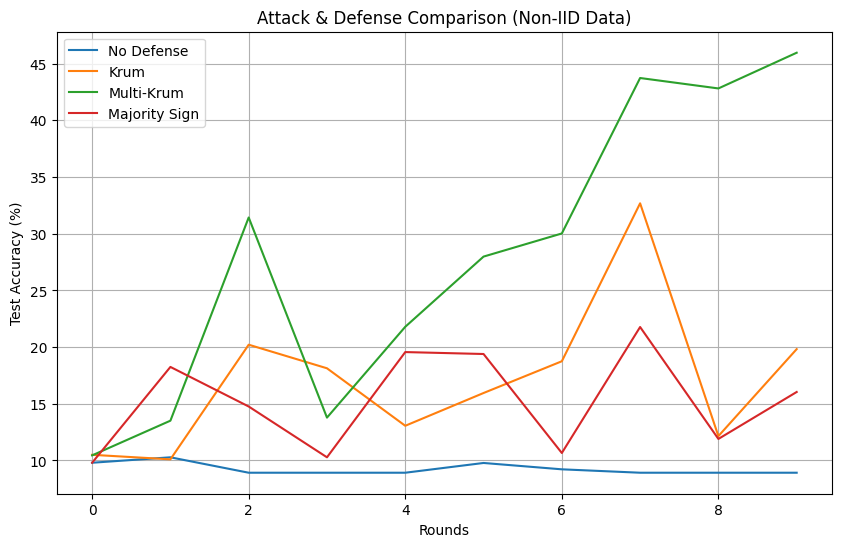

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_no_defense['Test accuracy'], label='No Defense')
plt.plot(df_krum['Test accuracy'], label='Krum')
plt.plot(df_multi_krum['Test accuracy'], label='Multi-Krum')
plt.plot(df_majority_sign['Test accuracy'], label='Majority Sign')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('Attack & Defense Comparison (Non-IID Data)')
plt.legend()
plt.grid()
plt.show()

In the non-i.i.d. setting, each client has a skewed or biased subset of data, which makes the learning process harder and more vulnerable to attacks. We observe that without any defense, the test accuracy remains low and stagnant. However, the impact of defenses varies. While Krum and Majority Sign offer some improvements, Multi-Krum performs the best, reaching much higher accuracy. This difference suggests that defenses like Multi-Krum, which select multiple clients for aggregation, can better handle non-i.i.d. data by capturing a more diverse set of updates, making the system more robust compared to the i.i.d. case where all clients have similar data distributions.

## Question 2: Implementing Bulyan Defense (5 points)

[Bulyan defense](https://arxiv.org/abs/1802.07927) combines aspects of `multi-krum` and `trimmed-mean` to protect against sophisticated attacks in federated environments. In this question, you will implement Bulyan by modifying and combining the existing code in the [attacks_and_defenses.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_3/attacks_and_defenses.ipynb).

### Scoring:
- _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.

- _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.
- _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.

In [14]:
def bulyan(clients_updates, multi_krum_k=14, multi_krum_n=20, multi_krum_m=5, beta=0.4):
    """
    clients_updates: list of gradients (no indices!)

    multi_krum_k: number of gradients to select using multi-krum
    multi_krum_n: total number of clients
    multi_krum_m: number of attackers assumed
    beta: proportion for trimmed-mean
    """
    # Here clients_updates is just list of gradients
    updates_only = clients_updates
    updates_for_krum = list(enumerate(updates_only))  # create (index, update) tuples for multi_krum

    # Step 1: Select clients using multi_krum
    selected_indices = multi_krum(updates_for_krum, k=multi_krum_k, n=multi_krum_n, m=multi_krum_m)

    selected_updates = [clients_updates[i] for i in selected_indices]

    # Step 2: Apply trimmed-mean on selected clients
    parameter_wise_updates = list(zip(*selected_updates))
    n_attackers = int(len(selected_updates) * beta)

    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        stacked_updates = torch.stack(parameter_group, dim=0)
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        if n_attackers > 0 and stacked_updates.shape[0] > 2 * n_attackers:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates
        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient * 20)

    return trimmed_mean_gradients

In [15]:
fedavg_server_bulyan = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42, defense=bulyan
)

In [16]:
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)


    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)

class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(
                batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None):
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None):
        raise NotImplemented

class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor([
        [1., 0., 1.],
        [-10., 1., -10.],
        [-10., -10., 0.],
        [-10., 1., -10.],
        [1., 0., 1.]
    ])
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)


    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or \
                y_bot >= self.input_shape[2]:
            raise ValueError(f'Position of backdoor outside image limits:'
                             f'image: {self.input_shape}, but backdoor'
                             f'ends at ({x_bot}, {y_bot})')

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device) # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device) # )(-52.5678, 2.7537)


    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * \
                                        batch.inputs[:attack_portion] + \
                                        mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask

In [17]:
# Create the synthesizer object
synthesizer = PatternSynthesizer(poisoning_proportion=0.1)

In [18]:
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]

        return reversed_gradients

In [19]:
class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = num_to_manipulate*0.00001  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            #print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients

In [20]:
class AttackerBackdoor(GradWeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=False, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [2*(initial_weight - final_weight) for final_weight, initial_weight in zip(self.model.parameters(), initial_weights)]

        return [gradient.detach().cpu().clone() for gradient in gradients]

#### Training with AttackerGradientReversion

In [ ]:
fedavg_server_bulyan_reverse = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=bulyan)
clients = fedavg_server_bulyan_reverse.clients

num_malicious = int(0.20 * len(clients))
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_bulyan_reverse = fedavg_server_bulyan_reverse.run(10)
df_bulyan_reverse = result_bulyan_reverse.as_df()

#### Training with AttackerPartGradientReversion

In [ ]:
fedavg_server_bulyan_part = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=bulyan)
clients = fedavg_server_bulyan_part.clients

num_malicious = int(0.20 * len(clients))
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerPartGradientReversion(client_data, lr, batch_size, nr_epochs)

result_bulyan_part = fedavg_server_bulyan_part.run(10)
df_bulyan_part = result_bulyan_part.as_df()

#### Training with AttackerBackdoor

In [ ]:
fedavg_server_bulyan_backdoor = FedAvgServerDefenseCoordinate(0.02, 200, sample_split, 0.2, 2, 42, defense=bulyan)
clients = fedavg_server_bulyan_backdoor.clients

num_malicious = int(0.20 * len(clients))
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_bulyan_backdoor = fedavg_server_bulyan_backdoor.run(10)
df_bulyan_backdoor = result_bulyan_backdoor.as_df()

#### Results

In [ ]:
# Print the test accuracies
print("Bulyan vs Gradient Reversion Attack:\n", df_bulyan_reverse['Test accuracy'])
print("\nBulyan vs Partial Reversion Attack:\n", df_bulyan_part['Test accuracy'])
print("\nBulyan vs Backdoor Attack:\n", df_bulyan_backdoor['Test accuracy'])

Bulyan vs Gradient Reversion Attack:
 0    13.27
1    12.88
2    14.12
3    22.80
4    20.55
5    22.89
6    26.88
7    31.82
8    41.14
9    28.64
Name: Test accuracy, dtype: float64

Bulyan vs Partial Reversion Attack:
 0    10.62
1    10.10
2    20.49
3    19.56
4    19.80
5    34.75
6    27.03
7    38.06
8    43.95
9    33.54
Name: Test accuracy, dtype: float64

Bulyan vs Backdoor Attack:
 0     8.92
1    10.10
2     9.74
3    25.04
4    13.31
5    27.86
6    14.02
7    16.31
8    12.10
9    31.96
Name: Test accuracy, dtype: float64


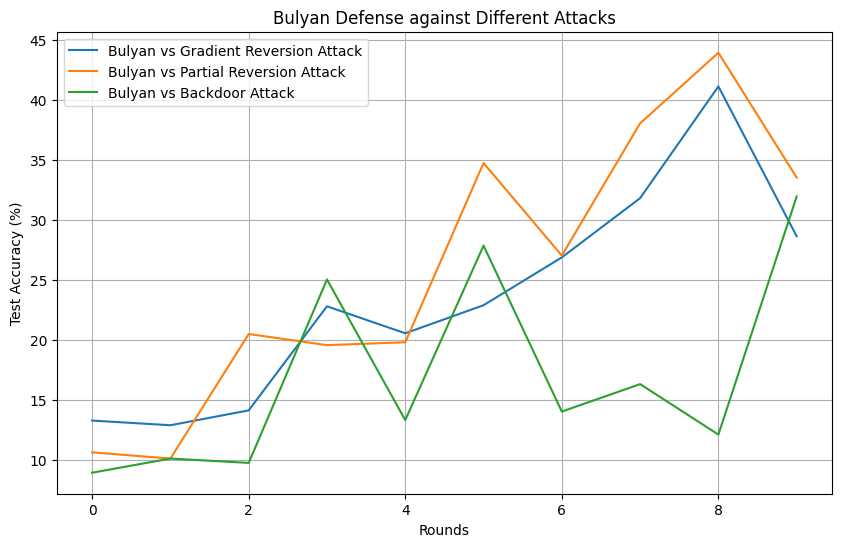

In [ ]:
# Plotting the test accuracies
plt.figure(figsize=(10, 6))

plt.plot(df_bulyan_reverse['Test accuracy'], label='Bulyan vs Gradient Reversion Attack')
plt.plot(df_bulyan_part['Test accuracy'], label='Bulyan vs Partial Reversion Attack')
plt.plot(df_bulyan_backdoor['Test accuracy'], label='Bulyan vs Backdoor Attack')

plt.xlabel('Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('Bulyan Defense against Different Attacks')
plt.legend()
plt.grid(True)
plt.show()

The Bulyan defense was evaluated against three types of attacks—Gradient Reversion, Partial Reversion, and Backdoor—across 10 training rounds. The results show that Bulyan provides increasing robustness over time, especially against Gradient and Partial Reversion attacks, achieving test accuracies of over 40% by the final round. Although the accuracy under Backdoor attack was generally lower, Bulyan still maintained a clear improvement compared to earlier rounds. These results confirm that Bulyan's combination of multi-krum and trimmed-mean effectively filters out malicious gradients, making the training more resilient to different attack types while preserving performance on i.i.d. data.

## Question 3: Implementing SparseFed Defense (7 points)

In this exercise, you will implement the [SparseFed Defense](https://arxiv.org/abs/2112.06274). SparseFed Defense involves two main steps for each participating device during the training process:
1. **Clipping the gradient:** Each device clips its gradient to reduce the impact of potentially malicious updates.
2. **Aggregating top-k updates:** During the aggregation phase, only the gradients with the highest magnitudes (top-k) are considered. This method is designed to minimize the risk of model poisoning by excluding anomalous gradient contributions from potentially compromised devices.

### Scoring:
- _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

- _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

- _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.


![image.png](attachment:40764930-c1b4-4b6c-84d2-cc6f43c6b402.png)

In [10]:
sample_split = split(100, True, 42)  # i.i.d. data

In [11]:
def sparsefed_defense(clients_updates, clip_norm=10.0, topk_ratio=0.2):
    clipped_updates = []
    for gradients in clients_updates:
        flat_grad = torch.cat([g.flatten() for g in gradients])
        norm = torch.norm(flat_grad, p=2)
        scale = min(1.0, clip_norm / (norm + 1e-6))
        scaled_flat_grad = flat_grad * scale

        reshaped_grads = []
        pointer = 0
        for g in gradients:
            numel = g.numel()
            reshaped_grads.append(scaled_flat_grad[pointer:pointer+numel].view_as(g))
            pointer += numel
        clipped_updates.append(reshaped_grads)

    parameter_wise_updates = list(zip(*clipped_updates))
    averaged_updates = [torch.mean(torch.stack(updates), dim=0) for updates in parameter_wise_updates]

    flat_avg_grad = torch.cat([g.flatten() for g in averaged_updates])
    k = int(topk_ratio * flat_avg_grad.numel())
    topk_indices = torch.topk(flat_avg_grad.abs(), k, largest=True, sorted=False)[1]
    mask = torch.zeros_like(flat_avg_grad)
    mask[topk_indices] = 1
    sparse_grad = flat_avg_grad * mask

    sparse_updates = []
    pointer = 0
    for g in averaged_updates:
        numel = g.numel()
        sparse_updates.append(sparse_grad[pointer:pointer+numel].view_as(g))
        pointer += numel

    return sparse_updates

#### Top-k = 20% with AttackerGradientReversion

In [12]:
topk_ratio = 0.2
fedavg_server = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42,
    defense=lambda x: sparsefed_defense(x, clip_norm=10.0, topk_ratio=topk_ratio)
)
clients = fedavg_server.clients
num_malicious = int(0.20 * len(clients))
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

result_20_reverse = fedavg_server.run(10)
df_20_reverse = result_20_reverse.as_df()

#### Top-k = 20% with AttackerBackdoor

In [21]:
topk_ratio = 0.2
fedavg_server = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42,
    defense=lambda x: sparsefed_defense(x, clip_norm=10.0, topk_ratio=topk_ratio)
)
clients = fedavg_server.clients
num_malicious = int(0.20 * len(clients))
malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

for idx in malicious_indices:
    client_data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    batch_size = clients[idx].loader_train.batch_size
    nr_epochs = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(client_data, lr, batch_size, nr_epochs)

result_20_backdoor = fedavg_server.run(10)
df_20_backdoor = result_20_backdoor.as_df()

#### Top-k = 50% with AttackerGradientReversion

In [22]:
fedavg_server_50_reverse = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42,
    defense=lambda x: sparsefed_defense(x, clip_norm=10.0, topk_ratio=0.5)
)
clients = fedavg_server_50_reverse.clients
malicious_indices = np.random.choice(len(clients), int(0.2 * len(clients)), replace=False)

for idx in malicious_indices:
    data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    bs = clients[idx].loader_train.batch_size
    ep = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(data, lr, bs, ep)

result_50_reverse = fedavg_server_50_reverse.run(10)
df_50_reverse = result_50_reverse.as_df()

#### Top-k = 50% with AttackerBackdoor

In [23]:
fedavg_server_50_backdoor = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42,
    defense=lambda x: sparsefed_defense(x, clip_norm=10.0, topk_ratio=0.5)
)
clients = fedavg_server_50_backdoor.clients
malicious_indices = np.random.choice(len(clients), int(0.2 * len(clients)), replace=False)

for idx in malicious_indices:
    data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    bs = clients[idx].loader_train.batch_size
    ep = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(data, lr, bs, ep)

result_50_backdoor = fedavg_server_50_backdoor.run(10)
df_50_backdoor = result_50_backdoor.as_df()

#### Top-k = 80% with AttackerGradientReversion

In [24]:
fedavg_server_80_reverse = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42,
    defense=lambda x: sparsefed_defense(x, clip_norm=10.0, topk_ratio=0.8)
)
clients = fedavg_server_80_reverse.clients
malicious_indices = np.random.choice(len(clients), int(0.2 * len(clients)), replace=False)

for idx in malicious_indices:
    data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    bs = clients[idx].loader_train.batch_size
    ep = clients[idx].nr_epochs
    clients[idx] = AttackerGradientReversion(data, lr, bs, ep)

result_80_reverse = fedavg_server_80_reverse.run(10)
df_80_reverse = result_80_reverse.as_df()

#### Top-k = 80% with AttackerBackdoor

In [25]:
fedavg_server_80_backdoor = FedAvgServerDefenseCoordinate(
    0.02, 200, sample_split, 0.2, 2, 42,
    defense=lambda x: sparsefed_defense(x, clip_norm=10.0, topk_ratio=0.8)
)
clients = fedavg_server_80_backdoor.clients
malicious_indices = np.random.choice(len(clients), int(0.2 * len(clients)), replace=False)

for idx in malicious_indices:
    data = clients[idx].loader_train.dataset
    lr = clients[idx].optimizer.param_groups[0]['lr']
    bs = clients[idx].loader_train.batch_size
    ep = clients[idx].nr_epochs
    clients[idx] = AttackerBackdoor(data, lr, bs, ep)

result_80_backdoor = fedavg_server_80_backdoor.run(10)
df_80_backdoor = result_80_backdoor.as_df()

#### Results

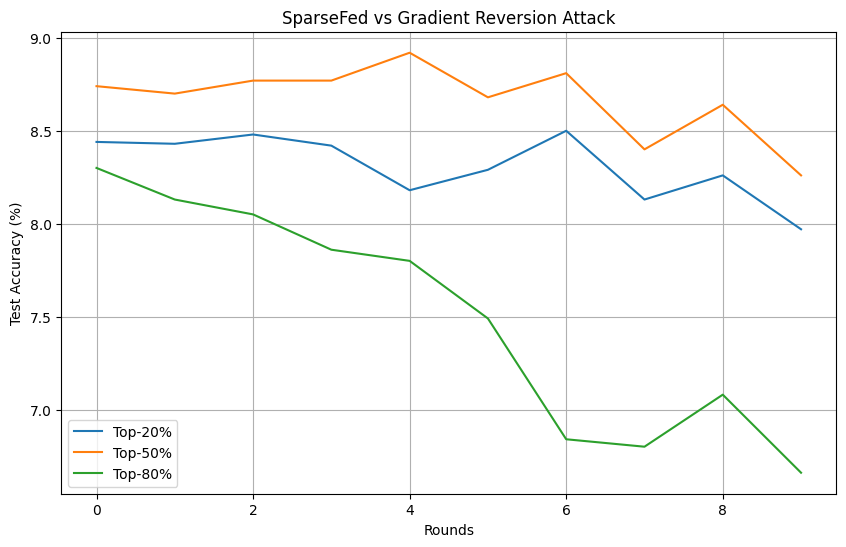

SparseFed vs Gradient Reversion Attack (Test Accuracy over Rounds):

Top-20%:
 8.44
8.43
8.48
8.42
8.18
8.29
8.50
8.13
8.26
7.97

Top-50%:
 8.74
8.70
8.77
8.77
8.92
8.68
8.81
8.40
8.64
8.26

Top-80%:
 8.30
8.13
8.05
7.86
7.80
7.49
6.84
6.80
7.08
6.66


In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df_20_reverse['Test accuracy'], label='Top-20%')
plt.plot(df_50_reverse['Test accuracy'], label='Top-50%')
plt.plot(df_80_reverse['Test accuracy'], label='Top-80%')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('SparseFed vs Gradient Reversion Attack')
plt.legend()
plt.grid()
plt.show()

print("SparseFed vs Gradient Reversion Attack (Test Accuracy over Rounds):\n")
print("Top-20%:\n", df_20_reverse['Test accuracy'].to_string(index=False))
print("\nTop-50%:\n", df_50_reverse['Test accuracy'].to_string(index=False))
print("\nTop-80%:\n", df_80_reverse['Test accuracy'].to_string(index=False))

Here for the Gradient Reversion Attack results, we can see that the performance of SparseFed depends strongly on the top-k sparsification level. The model with Top-50% sparsification achieves the best and most stable test accuracy across all 10 rounds, staying around 8.7–8.9%. The Top-20% model also performs reasonably well, although slightly less stable and with a small drop near the end. On the other hand, the Top-80% model performs the worst, with test accuracy dropping sharply after round 4 and falling to 6.66% by round 9. This shows that using a higher sparsification level (like Top-50%) helps filter out malicious gradients more effectively, improving the model’s robustness. However, when too many gradients are included (Top-80%), the defense becomes weak, and the attack has a stronger negative impact.

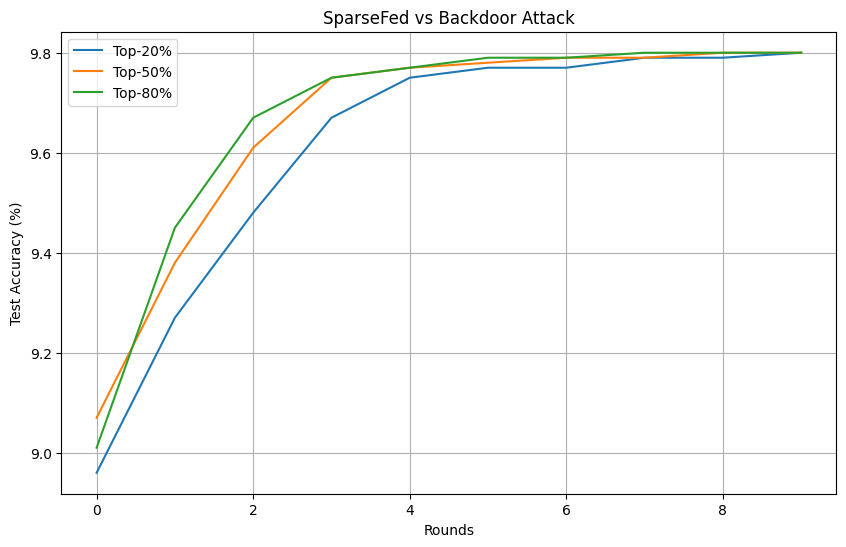

SparseFed vs Backdoor Attack (Test Accuracy over Rounds):

Top-20%:
 8.96
9.27
9.48
9.67
9.75
9.77
9.77
9.79
9.79
9.80

Top-50%:
 9.07
9.38
9.61
9.75
9.77
9.78
9.79
9.79
9.80
9.80

Top-80%:
 9.01
9.45
9.67
9.75
9.77
9.79
9.79
9.80
9.80
9.80


In [28]:
plt.figure(figsize=(10, 6))
plt.plot(df_20_backdoor['Test accuracy'], label='Top-20%')
plt.plot(df_50_backdoor['Test accuracy'], label='Top-50%')
plt.plot(df_80_backdoor['Test accuracy'], label='Top-80%')
plt.xlabel('Rounds')
plt.ylabel('Test Accuracy (%)')
plt.title('SparseFed vs Backdoor Attack')
plt.legend()
plt.grid()
plt.show()

print("SparseFed vs Backdoor Attack (Test Accuracy over Rounds):\n")
print("Top-20%:\n", df_20_backdoor['Test accuracy'].to_string(index=False))
print("\nTop-50%:\n", df_50_backdoor['Test accuracy'].to_string(index=False))
print("\nTop-80%:\n", df_80_backdoor['Test accuracy'].to_string(index=False))


Here for the Backdoor Attack results, we can see that all three levels of sparsification (Top-20%, Top-50%, and Top-80%) result in high and very similar test accuracy values by the end of training, reaching up to 9.80%. While there are small differences in the first few rounds (with Top-80% rising a bit faster), all three models converge to almost the same performance. This suggests that SparseFed is quite effective at defending against the Backdoor Attack, regardless of the exact sparsification level. The reason might be that the clipping step already limits harmful updates, and the nature of the backdoor attack is easier to suppress compared to the gradient reversion attack. Overall, sparsification did not harm the model's performance here and even helped slightly in the early rounds.

### For any questions regarding this assignment, send an email to c.zhu-2@tudelft.nl